In [24]:
%matplotlib inline

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.backends.backend_pdf import PdfPages
import dpkt
import numpy as np
import time
import brewer2mpl
import AttackAnalysis

from AttackAnalysis import compute_effective_rate
from analyze import compute_global_throughput, parse_file, removeOutliers, compute_tcp_opt_count
from read_conf import ReadHosts

reload(AttackAnalysis)

host_to_ip, ip_to_host = ReadHosts('experiment_oak_clone.conf')
interval = 5
root_level = 'workdir/results-nping/'

In [2]:
linestyles = ['-', '--', '-.', ':']
markers = []
for m in Line2D.markers:
    try:
        if len(m) == 1 and m != ' ':
            markers.append(m)
    except TypeError:
        pass

styles = markers + [
    r'$\lambda$',
    r'$\bowtie$',
    r'$\circlearrowleft$',
    r'$\clubsuit$',
    r'$\checkmark$']

In [3]:
def get_througput_array (entry, interval_s):
    num_buckets = np.size(entry.inbytes)
    buckets = np.arange(0, num_buckets * interval_s, interval_s)

    bps = 10e-6 * entry.inbytes * 8 / interval_s
    
    return buckets, bps

In [4]:
def compute_everything(prefix='results-nping-', capfile='servernode-log_agent-tcpdump.cap',
                       verbose=False, postfix=['nodefense','cookies','challenges'], 
                       shost='servernode'):
    throughput = {}
    for post in postfix:
        filename = root_level + prefix + post
        print "Generating throughput for %s" % filename
        filename += '/' + capfile

        start_time = time.time()
        throughput[post] = compute_global_throughput(filename, interval, host_to_ip[shost])
        end_time = time.time()
        if verbose:
            print "Time taken is ", end_time - start_time
            
    return throughput

In [27]:
def plot_throughput(in_throughput, in_host_to_ip, postfix=['nodefense','cookies','challenges'], host='clientnode-1',
                   yincr=5, ylimincr=5):
    

    bmap = brewer2mpl.get_map('PuOr', 'Diverging', 4)
    colors = bmap.mpl_colors

    #pp = PdfPages('throughput-exp2.pdf')
    
    params = {
       'axes.labelsize': 9,
       'text.fontsize': 10,
       'legend.fontsize': 9,
       'legend.handlelength': 2,
       'xtick.labelsize': 8,
       'ytick.labelsize': 8,
       'text.usetex': False,
       'figure.figsize': [9, 3]
       }
    plt.rcParams.update(params)

    fig = plt.figure()
    k = 1
    host_ip = in_host_to_ip[host]
    l = []
    plotnum = 0
    for post in postfix:
        maxbps = 0

        ax = fig.add_subplot(1,len(postfix),k)
        th = in_throughput[post]
        host_th = th[host_ip]

        host_bucket, host_bps = get_througput_array (host_th, interval_s=interval)

        l1, = ax.plot(host_bucket, host_bps, marker=None, markerfacecolor='none', 
                label=post, linewidth=2, color=colors[plotnum])

        l.append (l1)
        maxbps = np.maximum(maxbps, np.max(host_bps))

        # plt.title(plt_title[k-1])
        ax.grid(axis='y', color="0.9", linestyle='-', linewidth=1)
        ax.set_ylim(-5, maxbps+ylimincr)
        ax.set_xticks([0,100,200,300,400,500,600])

        # set y ticks
        yrange = np.arange (0,maxbps+ylimincr,yincr)
        ax.set_yticks(yrange)

        if k%2==0:
            ax.set_yticklabels([])

        #if k%2==0:
        #    
        if not k%2==0:
            ax.set_ylabel('Throughput (Mbps)')

        ax.set_xlabel('Time (seconds)')
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['left'].set_visible(False)
        ax.get_xaxis().tick_bottom()
        ax.get_yaxis().tick_left()
        ax.tick_params(axis='x', direction='out')
        ax.tick_params(axis='y', length=0)
        # offset the spines
        #for spine in ax.spines.values():
        #  spine.set_position(('outward', 5))
        # put the grid behind
        ax.set_axisbelow(True)
        ax.axvspan(120,480,color='red', alpha=0.1)

        k += 1
        plotnum += 1
        

    if len(fig.axes)%2 == 0:
        ax = fig.axes[-2]
    else:
        ax = fig.axes[-1]
    
    legend = ax.legend(l, postfix, loc = 9, ncol=5, bbox_to_anchor=(1.05, -0.15),borderaxespad=1.0)
    frame = legend.get_frame()
    frame.set_facecolor('1')
    frame.set_edgecolor('0.75')
 
    #plt.savefig('throughput-exp2.pdf', bbox_inches = 'tight')
    plt.show()
    #pp.savefig()
    #pp.close()

In [49]:
def plot_throughput_overimpose(in_throughput, in_host_to_ip, postfix=['nodefense','cookies','challenges'], 
                               host=['clientnode-1'], yincr=[5,50], ylimincr=[5,50], 
                               plt_title=['Client','Server'], ystart=[-2,-10], opt_d = opt_data ):
    

    bmap = brewer2mpl.get_map('PuRd', 'Sequential', 3)
    colors = bmap.mpl_colors

    #pp = PdfPages('throughput-exp2.pdf')
    
    params = {
       'axes.labelsize': 9,
       'text.fontsize': 10,
       'legend.fontsize': 9,
       'legend.handlelength': 2,
       'xtick.labelsize': 8,
       'ytick.labelsize': 8,
       'text.usetex': False,
       'figure.figsize': [6, 2]
       }
    plt.rcParams.update(params)

    #figure, ax = plt.subplots()
    fig = plt.figure()#figsize=(10,10))
    #fig.subplots_adjust(hspace = 0.5, wspace=0.1)
    k = 1
    #l = []
    #ax = plt.gca()
    
    for host_entry in host:
        host_ip = in_host_to_ip[host_entry]
        ax = fig.add_subplot(1,2,k)
        #ax.axis('off')
        
        plotnum = 0
        for post in postfix:
            maxbps = 0
            
            th = in_throughput[post]
            host_th = th[host_ip]

            host_bucket, host_bps = get_througput_array (host_th, interval_s=interval)
            
            ax.plot(host_bucket, host_bps, marker=None, markerfacecolor='none', 
                    label=post, linewidth=2, color=colors[plotnum])
            plotnum += 1
            
        #l.append (l1)
        maxbps = np.maximum(maxbps, np.max(host_bps))
        
        
        l_data_opt, l_ts_list, h_data_opt, h_ts_list = opt_data
        if host_entry == 'clientnode-1':
            ax.bar(h_ts_list,h_data_opt, color="yellow", linewidth=0, width=1, bottom=-0.5)
            ax.bar(l_ts_list,l_data_opt, color="red", linewidth=0, width=1, bottom=-0.5)

        plt.title(plt_title[k-1])
        ax.grid(axis='y', color="0.9", linestyle='-', linewidth=1)
        ax.set_ylim(ystart[k-1], maxbps+ylimincr[k-1])
        ax.set_xticks([0,100,200,300,400,500,600])
        ax.set_xlim(0,599)

        # set y ticks
        yrange = np.arange (0,maxbps+ylimincr[k-1],yincr[k-1])
        ax.set_yticks(yrange)

        #if k%2==0:
        #    ax.set_yticklabels([])

        #if k%2==0:
        #    
        if not k%2==0:
            ax.set_ylabel('Throughput (Mbps)')
        
        ax.set_xlabel('Time (seconds)')
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['left'].set_visible(False)
        ax.get_xaxis().tick_bottom()
        ax.get_yaxis().tick_left()
        ax.tick_params(axis='x', direction='out')
        ax.tick_params(axis='y', length=0)
        ax.set_axisbelow(True)

        ax.axvspan(120,480,color='red', alpha=0.1)
        k += 1
        

    if len(fig.axes)%2 == 0:
        ax = fig.axes[-2]
    else:
        ax = fig.axes[-1]
    
    legend = ax.legend(loc = 9, ncol=5, bbox_to_anchor=(1.05, -0.2),borderaxespad=1.0)
    frame = legend.get_frame()
    frame.set_facecolor('1')
    frame.set_edgecolor('0.75')
 
    plt.savefig('paper-plots/throughput-exp2-2.pdf', bbox_inches = 'tight')
    plt.show()
    #pp.savefig()
    #pp.close()

In [30]:
throughput_nodefense = compute_everything(verbose=True, postfix=['nodefense'])

Generating throughput for workdir/results-nping/results-nping-nodefense
Time to read pcap file 0.000245094299316
Time taken is  144.487287998


In [31]:
throughput_cookies = compute_everything(verbose=True, postfix=['cookies'])

Generating throughput for workdir/results-nping/results-nping-cookies
Time to read pcap file 0.000277042388916
Time taken is  161.950647831


In [32]:
throughput_ch_k17 = compute_everything(verbose=True, postfix=['challenges-m17'])

Generating throughput for workdir/results-nping/results-nping-challenges-m17
Time to read pcap file 0.000213146209717
Time taken is  42.9940881729


In [33]:
# temporary, remove when reloading the kernel
throughput = {}
throughput['nodefense'] = throughput_nodefense['nodefense']
throughput['cookies'] = throughput_cookies['cookies']
throughput['challenges-m17'] = throughput_ch_k17['challenges-m17']

In [34]:
print host_to_ip['clientnode-1']
l_data_opt, l_ts_list, h_data_opt, h_ts_list = computeEvents_opt()
opt_data = (l_data_opt, l_ts_list, h_data_opt, h_ts_list)

10.1.9.3
Generating throughput for workdir/results-nping/results-nping-challenges-m17
Time to read pcap file 0.000447988510132
Time taken is  40.6758539677


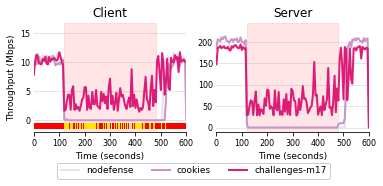

In [50]:
plot_throughput_overimpose(throughput, host_to_ip, postfix=['nodefense', 'cookies', 'challenges-m17'], 
                           host=['clientnode-1','servernode'], opt_d = opt_data )

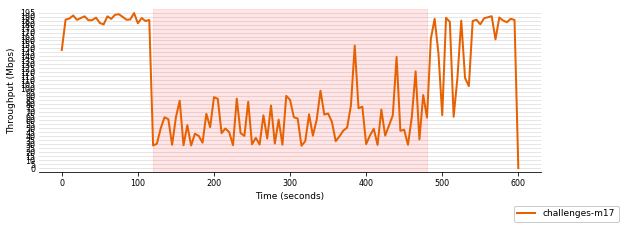

In [38]:
plot_throughput(throughput, host_to_ip, postfix=['challenges-m17'], 
                host='servernode')

# Attacker analysis

In [228]:
attack_file_template = 'attacknode-2-attack_log-tcpdump.cap'

cap_file = root_level + 'results-nping-cookies/' + attack_file_template

attacker_interval = 5
effective_rate = compute_effective_rate(cap_file, attacker_interval, False)

+----------------------------------------------------+
Statistics for host 10.1.5.4
Total number of attempted connections: 	138727
Total number of acked connections:     	10841
Total number of failed connections:    	127886
Total number of replies received:      	10841
Average ACK rate:                      	142.644736842
+----------------------------------------------------+


/usr/lib/pymodules/python2.7/matplotlib/collections.py:548: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == 'face':


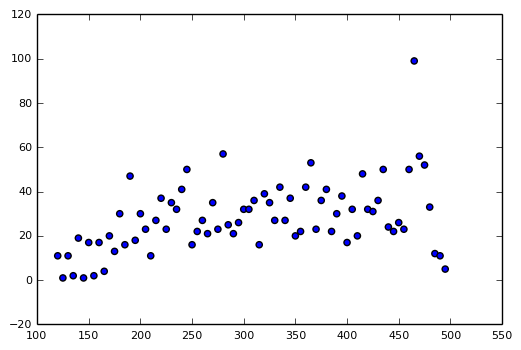

In [230]:
attacker_ip = host_to_ip['attacknode-2']
entry = effective_rate[attacker_ip]

num_buckets = np.size(entry)
buckets = np.arange(120, 120+num_buckets * attacker_interval, attacker_interval)
pps = entry/attacker_interval

plt.scatter(buckets, pps)

## Number of challenges

In [21]:
def computeEvents_opt():
    prefix='results-nping-'
    capfile='servernode-log_agent-tcpdump.cap'
    postfix='challenges-m17'
    shost='servernode'
    chost='clientnode-1'
    verbose = True

    #get pcap file    
    post = postfix
    filename = root_level + prefix + post
    print "Generating throughput for %s" % filename
    filename += '/' + capfile

    start_time = time.time()

    entry = compute_tcp_opt_count(filename, host_to_ip[chost])
    end_time = time.time()
    if verbose:
        print "Time taken is ", end_time - start_time
    
    l_data_opt = []
    l_ts_list = []

    h_data_opt = []
    h_ts_list = []
    ts_min = np.min(entry.keys())
    for ts in entry.keys():
        if entry[ts]==9:
            h_ts_list.append(ts-ts_min)
            h_data_opt.append(entry[ts]-10)
            #l_ts_list.append(ts-ts_min)
            #l_data_opt.append(0)
        else:
            l_ts_list.append(ts-ts_min)
            l_data_opt.append(entry[ts]-6)
            #h_ts_list.append(ts-ts_min)
            #h_data_opt.append(0)
    
    return (l_data_opt, l_ts_list, h_data_opt, h_ts_list)